# GLM models - variables non PCA - Cracow

In [1]:
%matplotlib inline
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from __future__ import print_function
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels import graphics
from statsmodels.graphics.api import abline_plot
from scipy import stats
from matplotlib import pyplot as plt
import warnings
import itertools
import seaborn as sns
from sklearn.metrics import r2_score
warnings.filterwarnings("ignore")
import math
import functools 
import operator

In [2]:
def convertTuple(tup): 
    str = functools.reduce(operator.add, (tup)) 
    return str

In [3]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize']=(18,10)

In [4]:
data = pd.read_pickle('data/cracow_journeys.pkl')

In [5]:
data = data.groupby('Date').agg({'Journeys':'sum', 'Cloud_cover':'mean', 'Wind_speed':'mean',
       'Temperature':'mean', 'Pressure':'mean', 'Precipitation':'mean',
       'comp_0':'mean', 'comp_1':'mean', 'comp_2':'mean', 'comp_3':'mean', 'comp_4':'mean','Season':'mean'}).reset_index()

In [6]:
cracow = data.copy()
cracow.Date = pd.to_datetime(cracow.Date)

In [7]:
cracow

Date  Journeys  Cloud_cover  Wind_speed  Temperature     Pressure  \
0   2019-01-01     895.0     7.333333    5.625000     2.550000   988.370833   
1   2019-01-02    3209.0     7.833333    6.875000     0.379167   983.708333   
2   2019-01-03    3672.0     6.958333    5.708333    -2.662500   993.520833   
3   2019-01-04    3457.0     7.583333    4.250000    -3.225000   995.825000   
4   2019-01-05     804.0     7.791667    5.166667     0.708333   984.433333   
..         ...       ...          ...         ...          ...          ...   
360 2019-12-27    3039.0     7.375000    4.208333     2.029167   993.975000   
361 2019-12-28    1984.0     7.958333    4.708333    -0.029167  1003.425000   
362 2019-12-29    2083.0     7.916667    2.000000    -1.341667  1008.575000   
363 2019-12-30    5399.0     6.541667    3.166667     0.125000  1003.408333   
364 2019-12-31    3928.0     6.083333    6.625000     4.433333   995.616667   

     Precipitation    comp_0    comp_1    comp_2    comp_3    comp_4  Season  
0         0.091667  1.709407 -1.004130 -0.410442  0.899036 -0.124129       4  
1         0.195833  2.718771 -0.769607 -0.738883  1.207612  0.264982       4  
2         0.025000  1.501121 -1.910966 -0.202301  1.112889  0.046122       4  
3         0.016667  1.175846 -2.001402  0.574084  0.605861 -0.334658       4  
4         0.204167  2.189998 -0.603717  0.018222  0.568699  0.125701       4  
..             ...       ...       ...       ...       ...       ...     ...  
360       0.020833  0.950485 -1.429825  0.282454  0.572786 -0.526376       4  
361       0.025000  0.888791 -2.172830  0.678161  1.440685 -0.934670       4  
362       0.000000 -0.119855 -2.392977  2.042766  0.618448 -1.260396       4  
363       0.000000 -0.010607 -2.039739  1.124608  0.831302 -0.596836       4  
364       0.000000  1.008390 -1.539932 -0.916919  1.807283 -0.172421       4  

[365 rows x 13 columns]

## Distribution of the dependent variable - Journeys

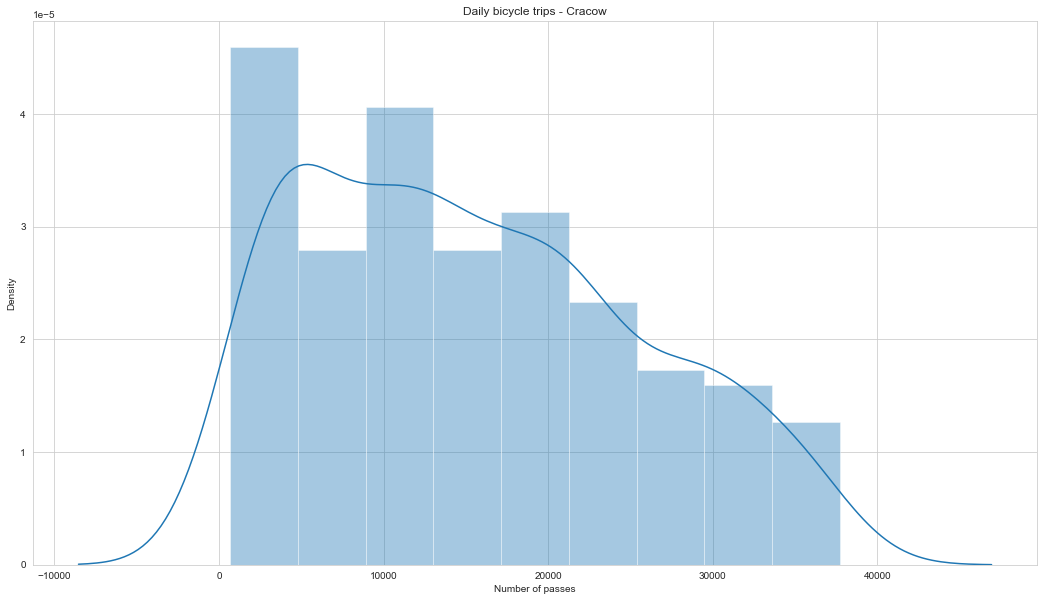

In [8]:
sns.distplot(cracow.Journeys, kde=True)
plt.title('Daily bicycle trips - Cracow')
plt.xlabel('Number of passes')
plt.show()

### The above distribution is closest to the Inverse Gaussian, Gamma (or Poisson) distribution

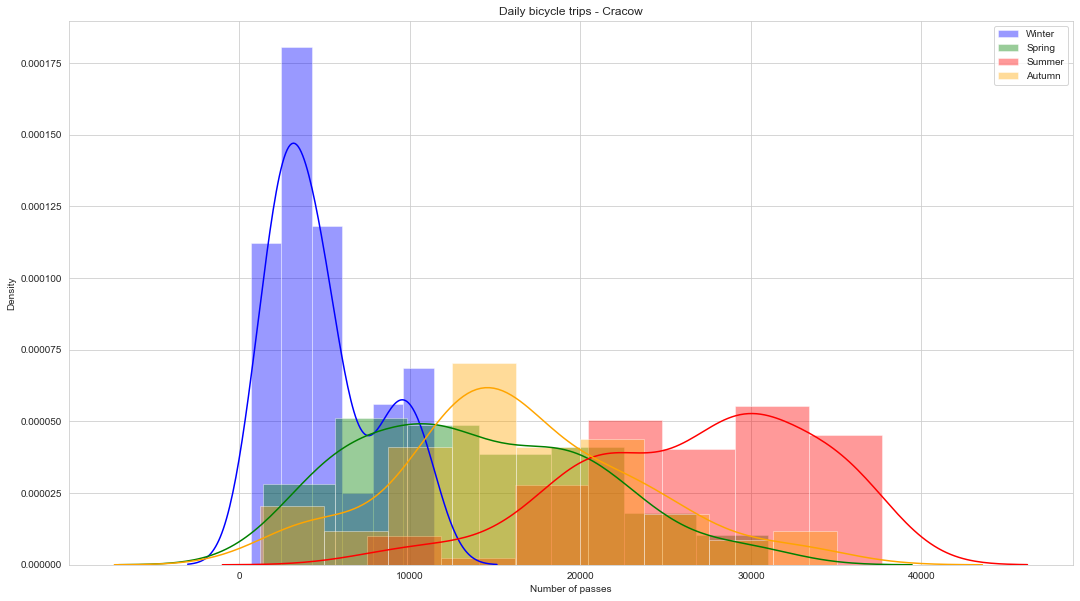

In [9]:
fig, ax = plt.subplots()
ax = sns.distplot(cracow.Journeys[cracow.Season == 4], kde=True, label='Winter', color='blue')
ax = sns.distplot(cracow.Journeys[cracow.Season == 1], kde=True, label='Spring', color='green')
ax = sns.distplot(cracow.Journeys[cracow.Season == 2], kde=True, label='Summer', color='red')
ax = sns.distplot(cracow.Journeys[cracow.Season == 3], kde=True, label='Autumn', color='orange')
plt.title('Daily bicycle trips - Cracow')
plt.legend()
plt.xlabel('Number of passes')
plt.show()

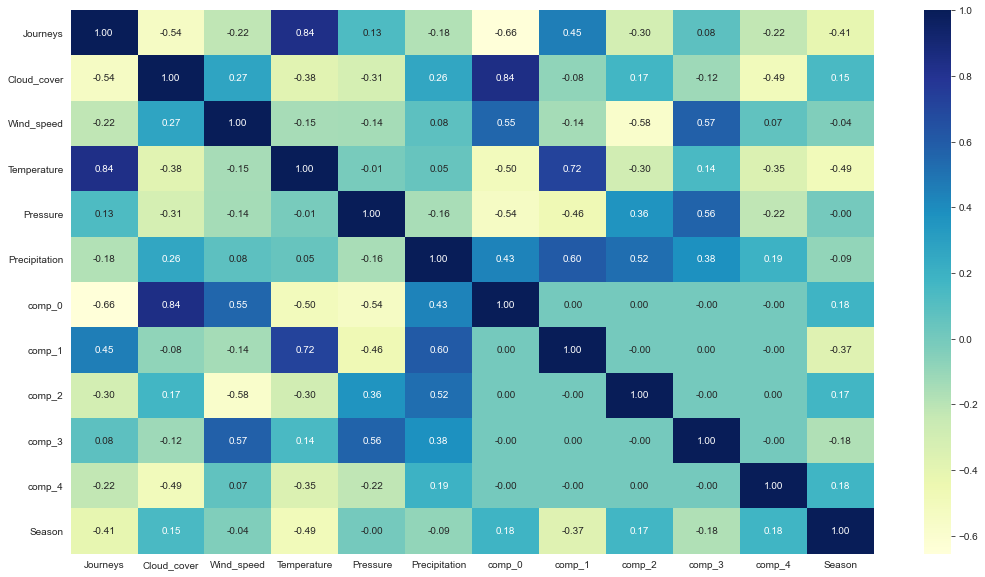

In [10]:
_ = sns.heatmap(cracow.corr(), cmap="YlGnBu", fmt='.2f', annot = True)

We standardize...

In [11]:
stdscaler = StandardScaler()
cracow['Temperature'] = stdscaler.fit_transform(cracow.Temperature.values.reshape(-1,1))
cracow['Cloud_cover'] = stdscaler.fit_transform(cracow.Cloud_cover.values.reshape(-1,1))
cracow['Wind_speed'] = stdscaler.fit_transform(cracow.Wind_speed.values.reshape(-1,1))

## Data modeling

In [12]:
columns = ['Temperature ', 'Cloud_cover ', 'Wind_speed ']

help_t = []
for i in range(0, len(columns)+1):
        for subset in itertools.combinations(columns, i):
                help_t.append(subset)                

formula =[]
for i in range(1,len(help_t)):
    x = convertTuple(help_t[i])
    f = '%s' % x
    g = f.split(' ')
    h=''
    h = ' + '.join(g)[:-3]
    formula.append(h)

#### GLM models

In [13]:
familia = [sm.families.Gaussian(link=sm.families.links.log()),
           
           sm.families.InverseGaussian(link=sm.families.links.identity()),
           sm.families.InverseGaussian(link=sm.families.links.log()),
           
           sm.families.Gamma(link=sm.families.links.identity()),
           sm.families.Gamma(link=sm.families.links.log()),
           
           sm.families.Poisson(link=sm.families.links.identity()),
           sm.families.Poisson(link=sm.families.links.log())          
          ]
familia2 = ['Gaussian','Inverse Gaussian','Inverse Gaussian','Gamma','Gamma','Poisson','Poisson']

Model No. 1



                 Generalized Linear Model Regression Results                  
Dep. Variable:               Journeys   No. Observations:                  365
Model:                            GLM   Df Residuals:                      363
Model Family:                Gaussian   Df Model:                            1
Link Function:                    log   Scale:                      3.3263e+07
Method:                          IRLS   Log-Likelihood:                -3677.8
Date:                Thu, 26 Aug 2021   Deviance:                   1.2074e+10
Time:                        16:43:00   Pearson chi2:                 1.21e+10
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       9.5446      0.025  

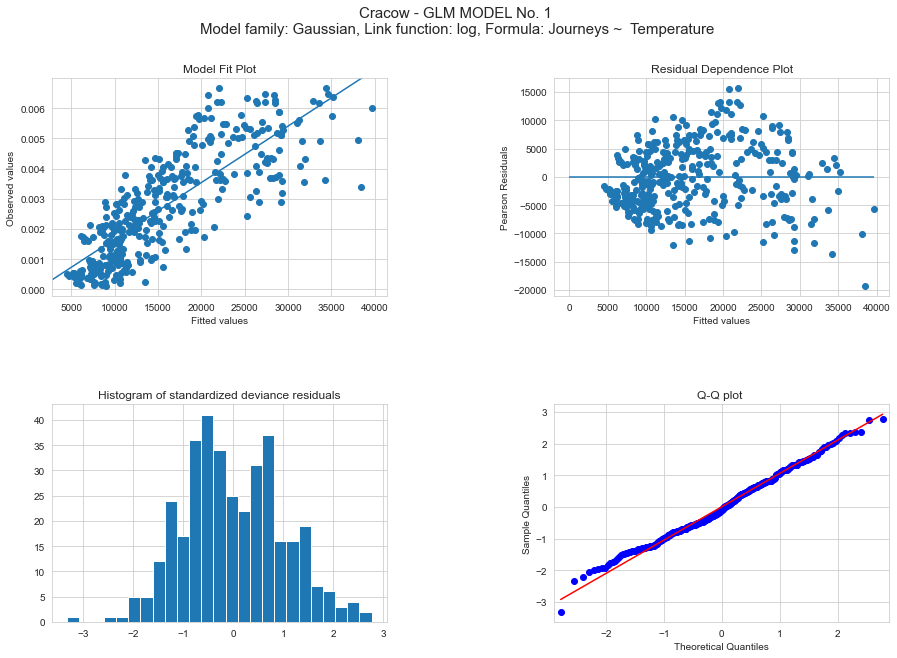

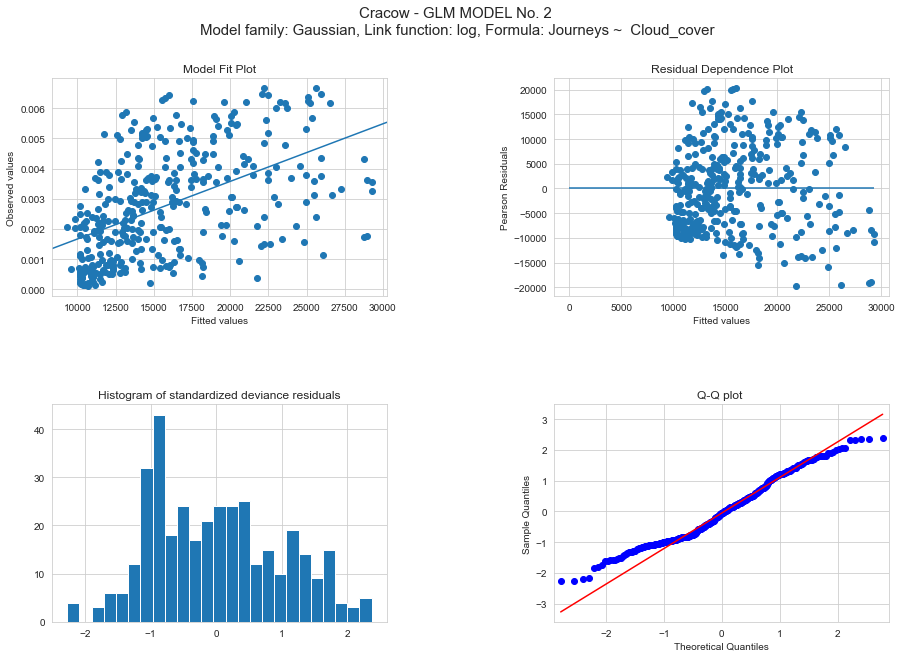

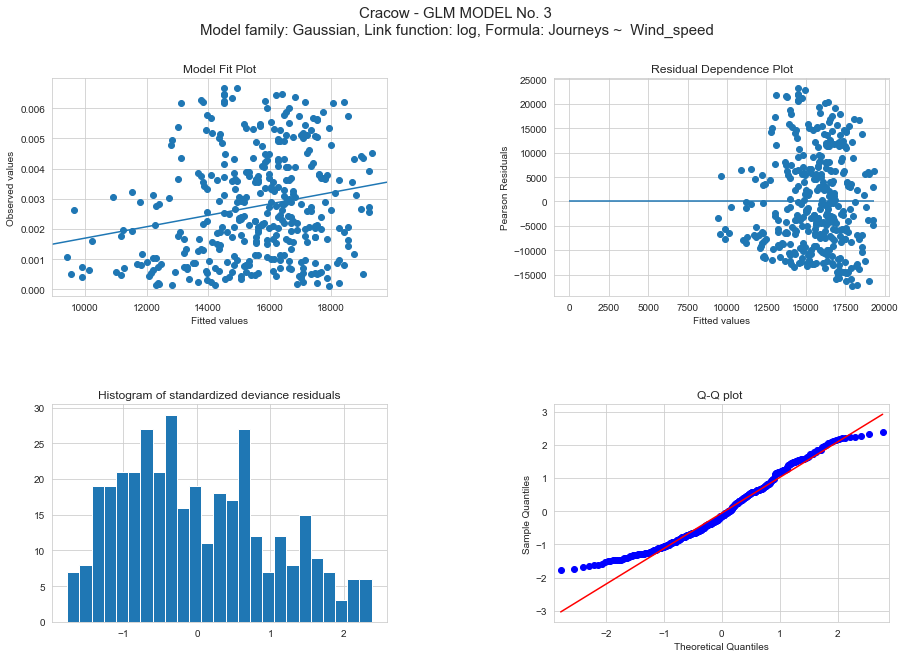

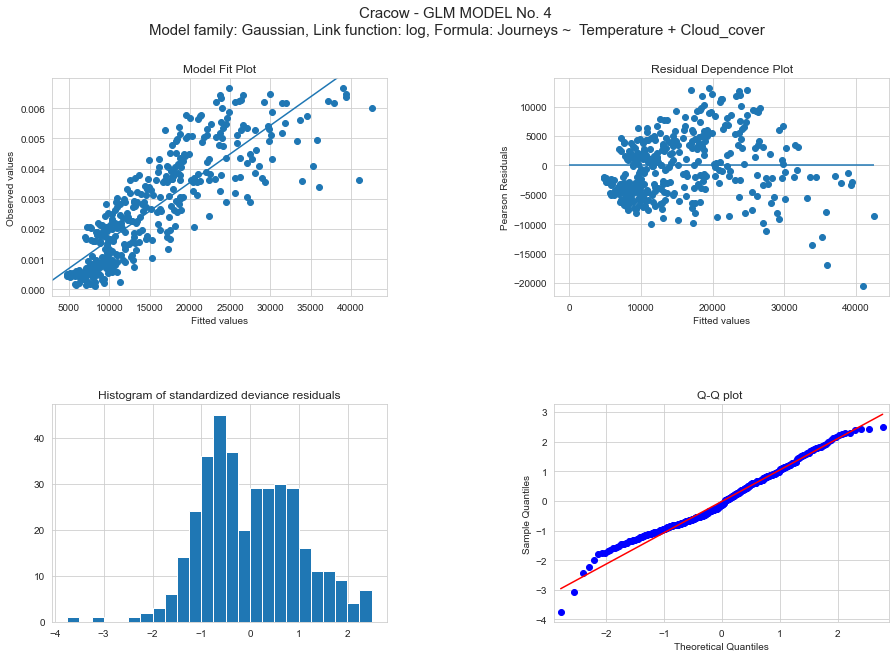

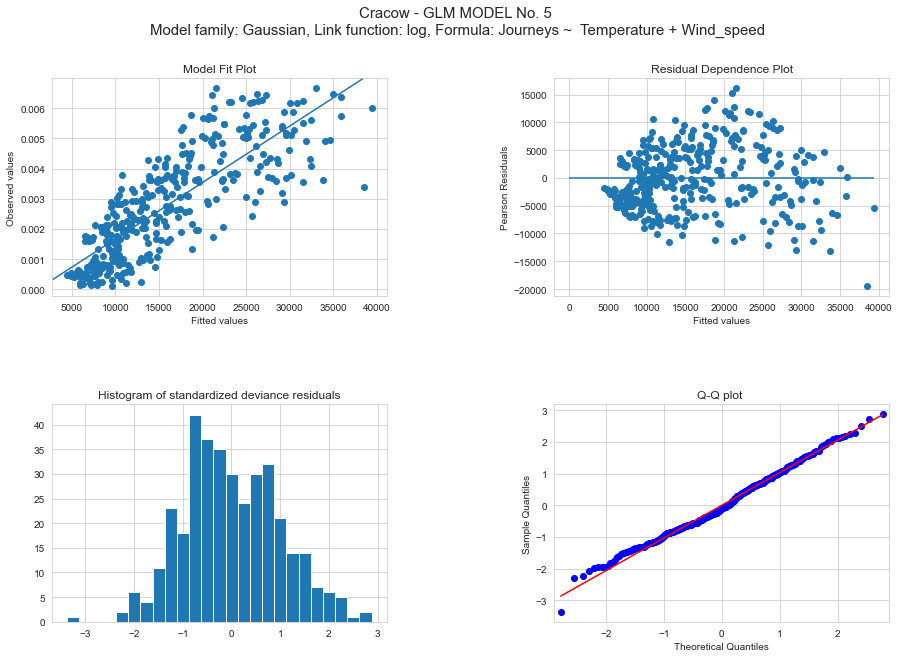

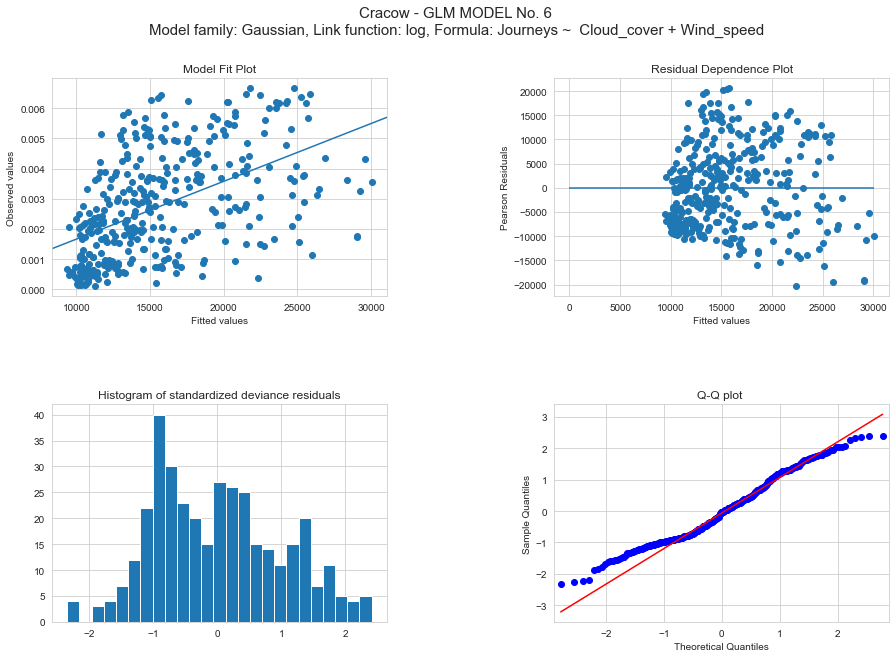

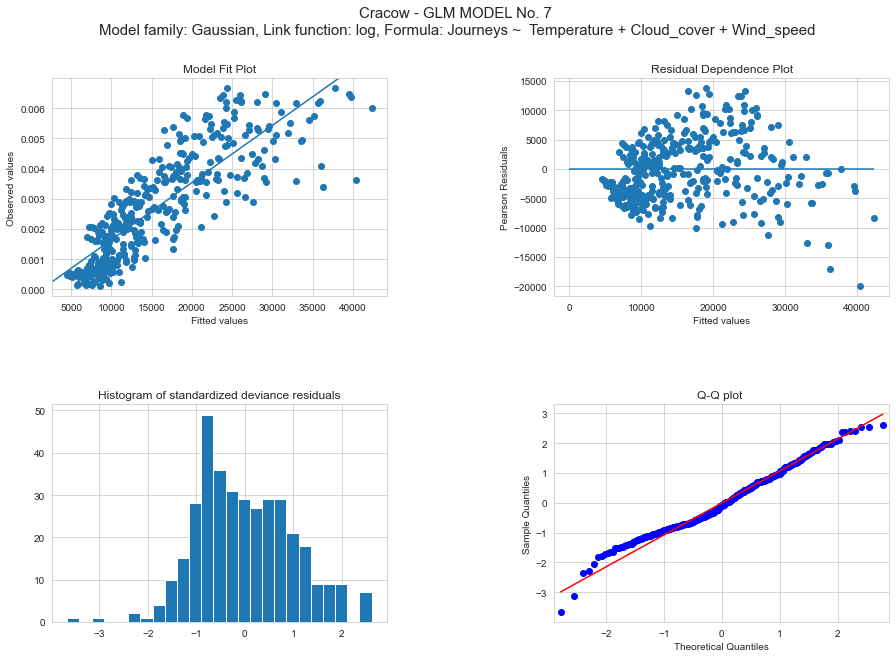

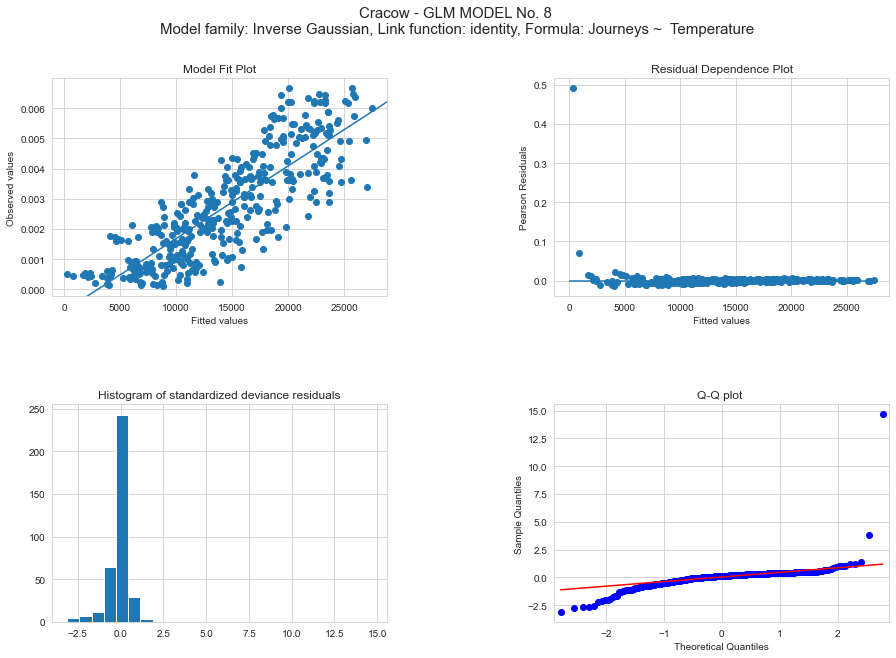

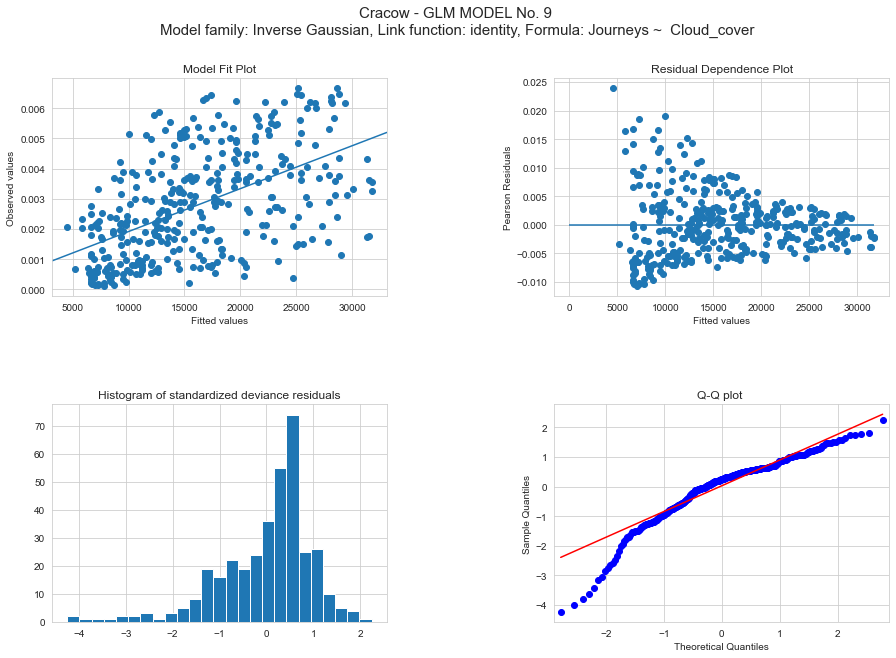

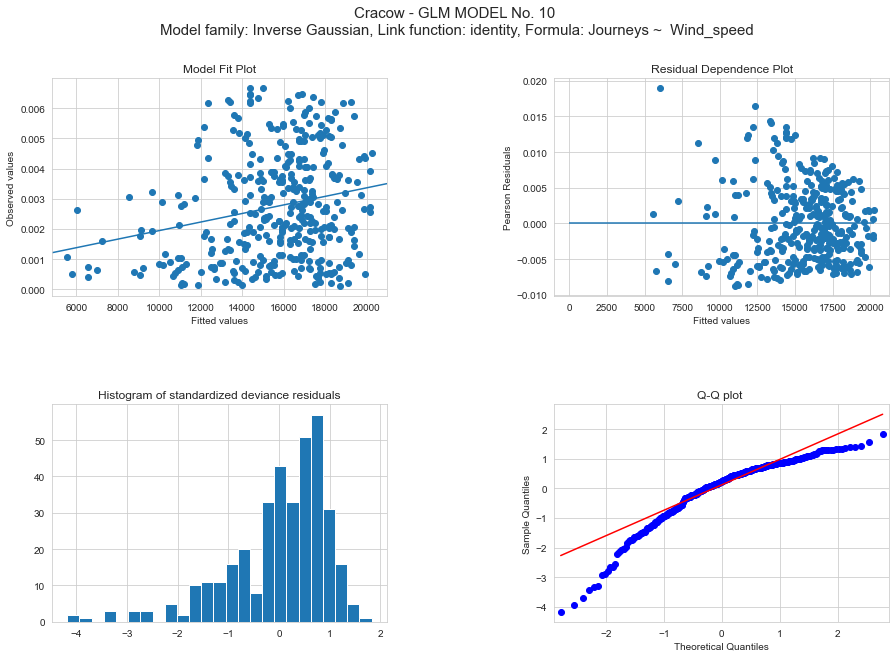

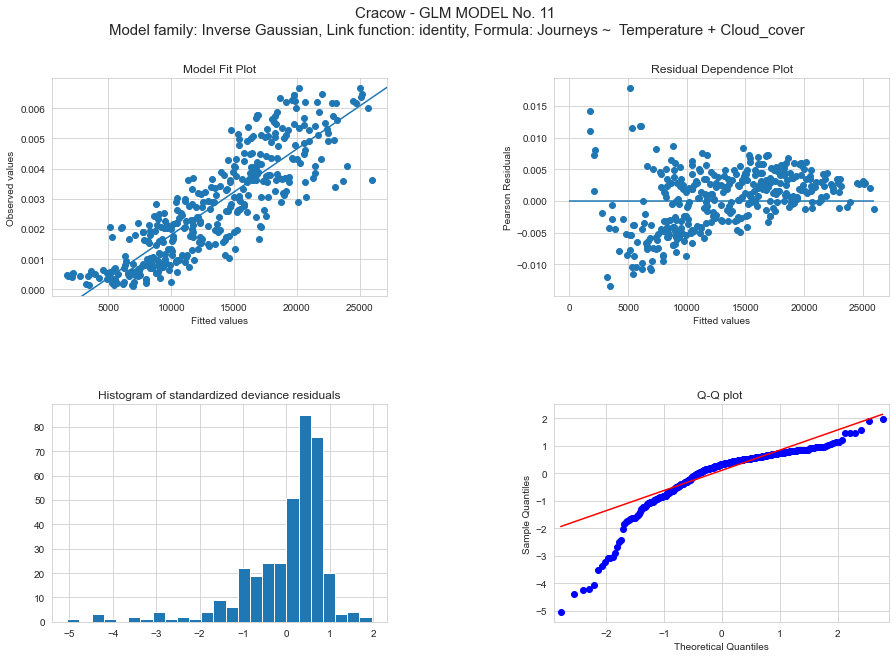

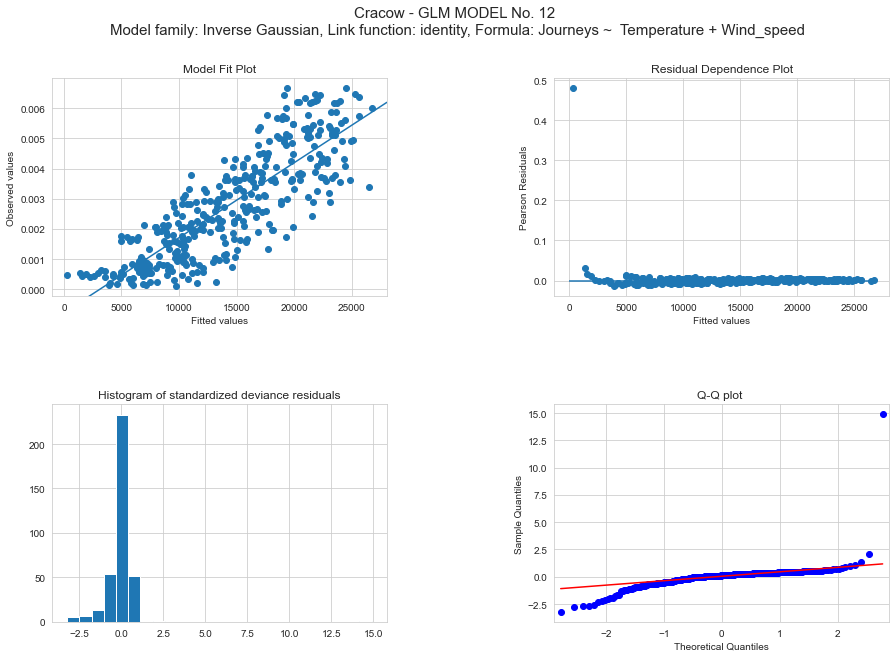

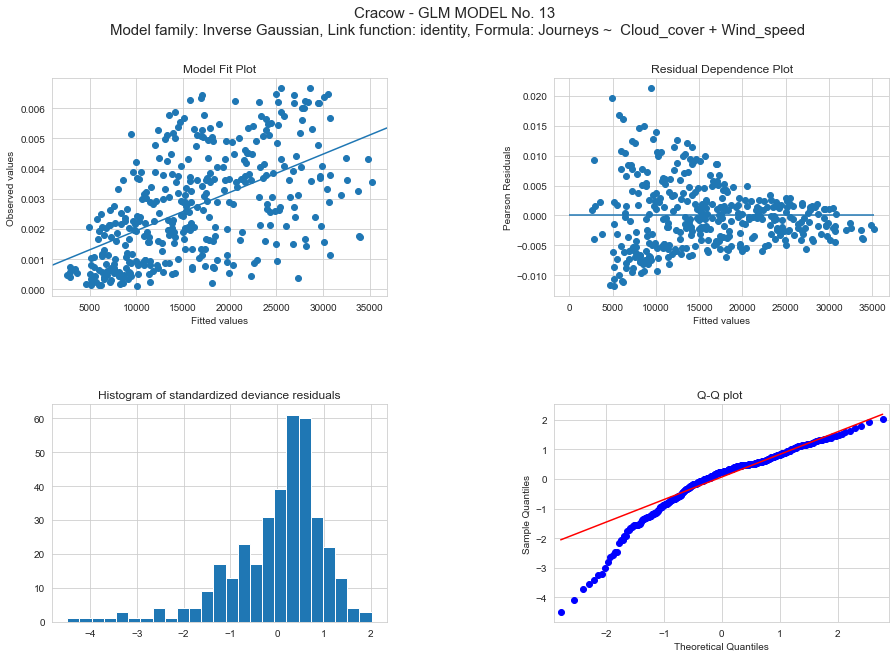

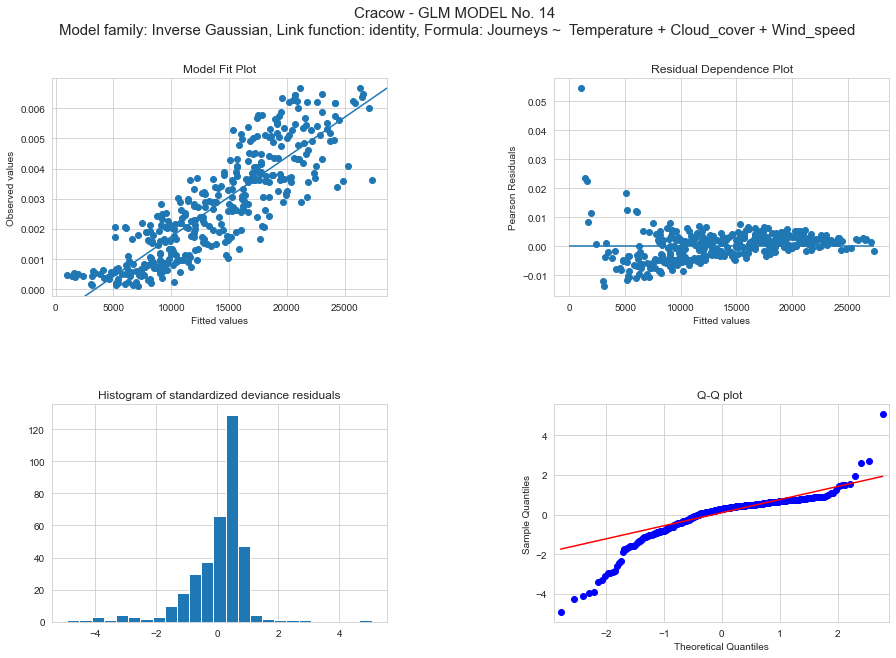

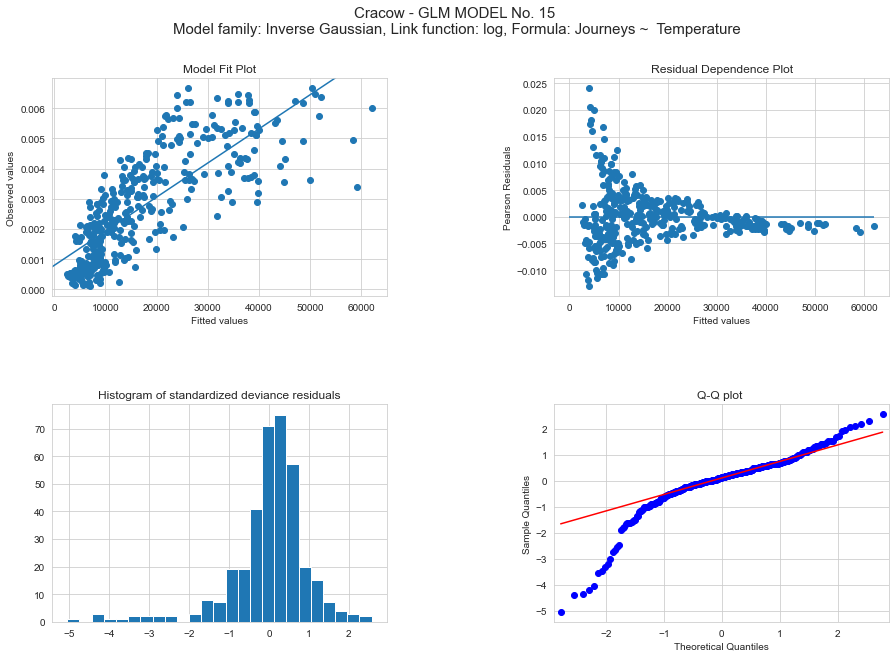

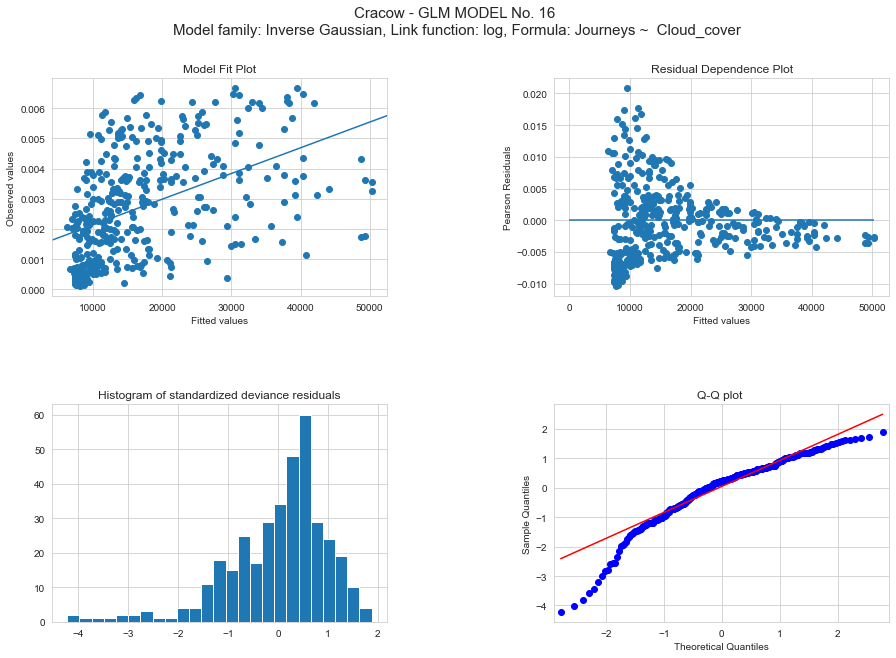

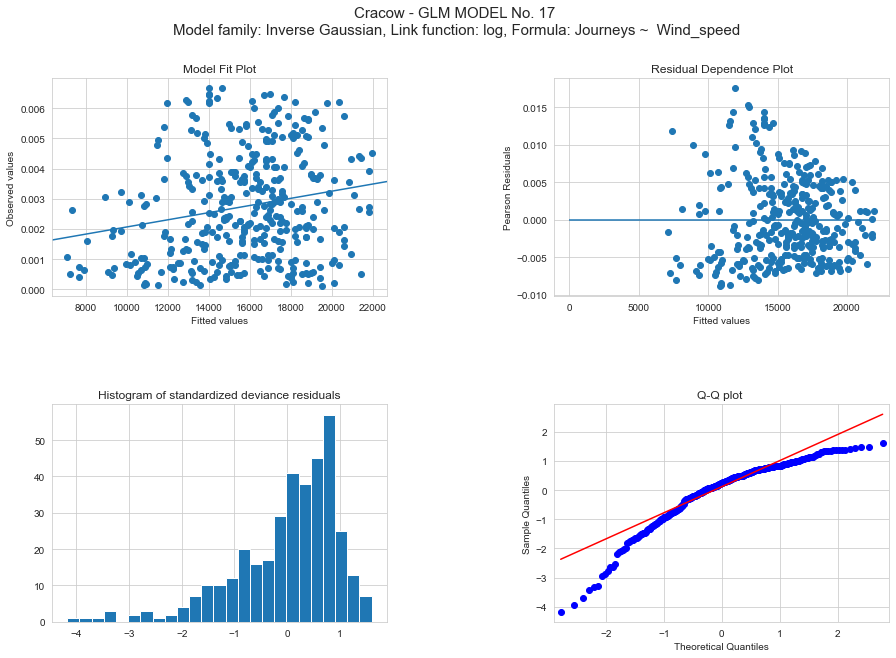

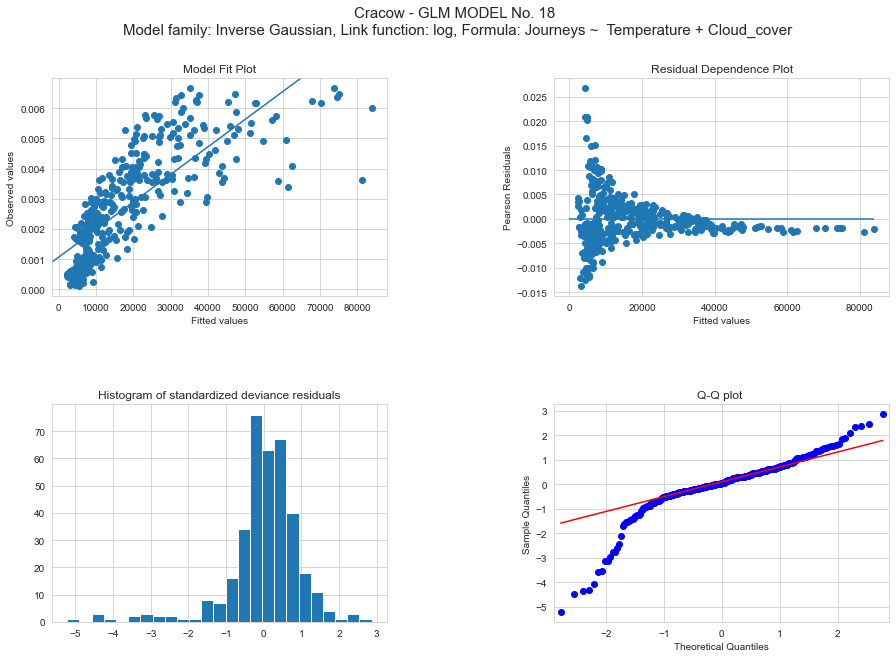

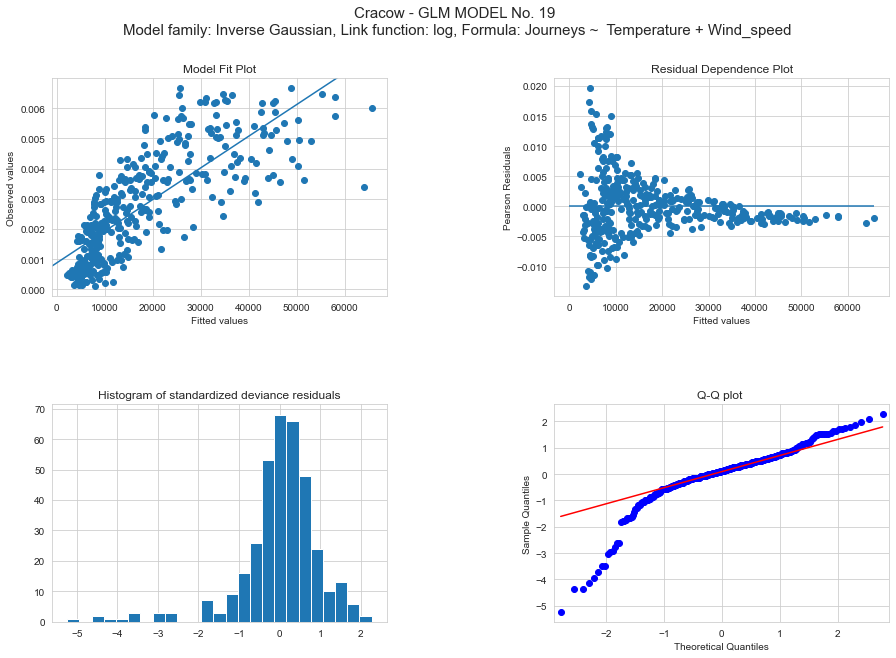

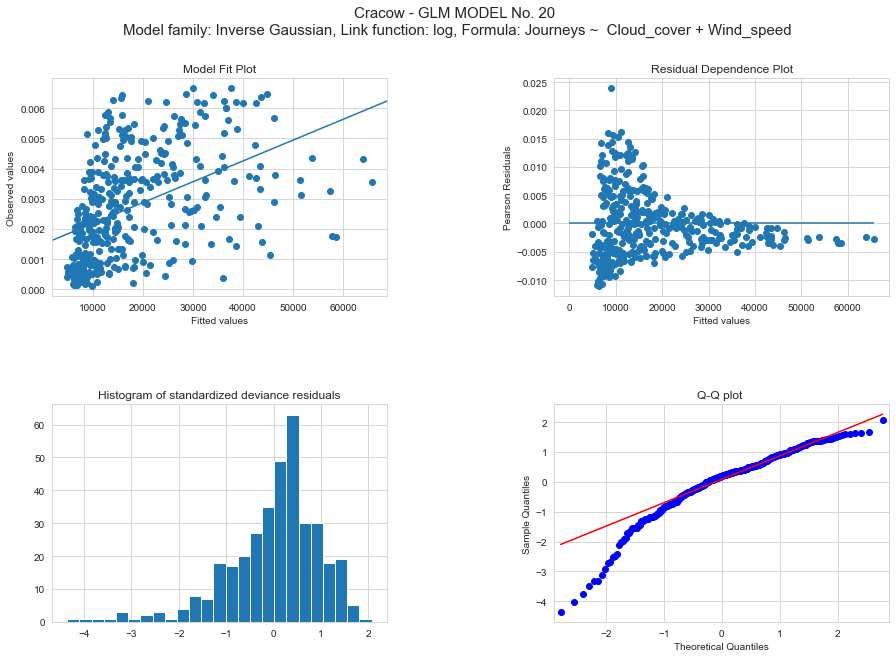

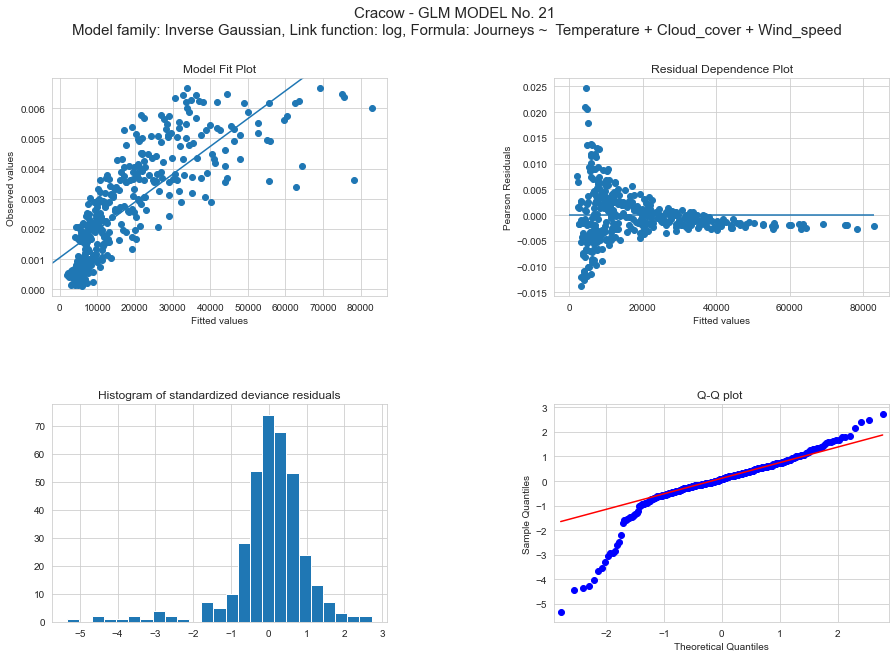

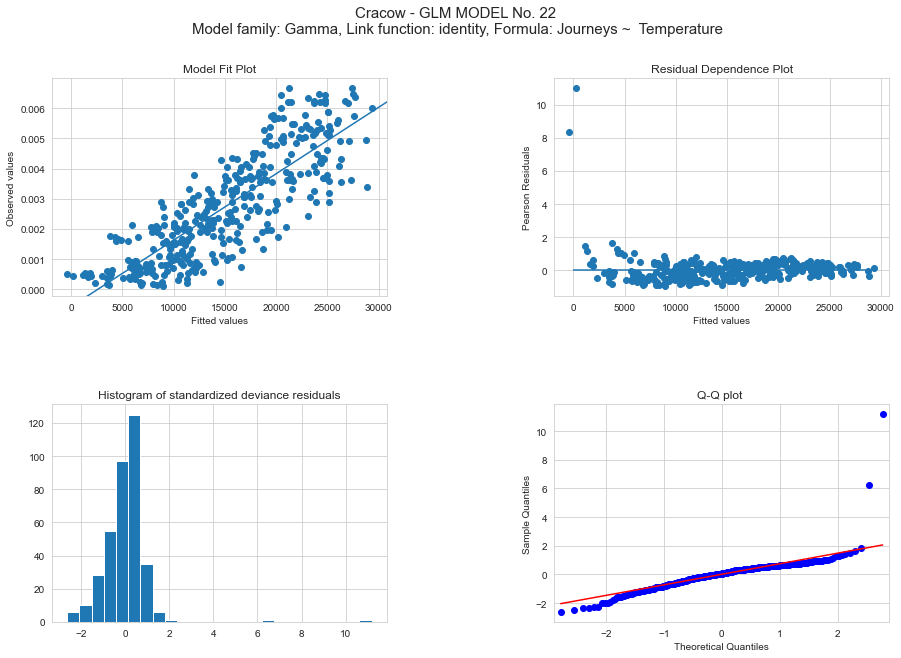

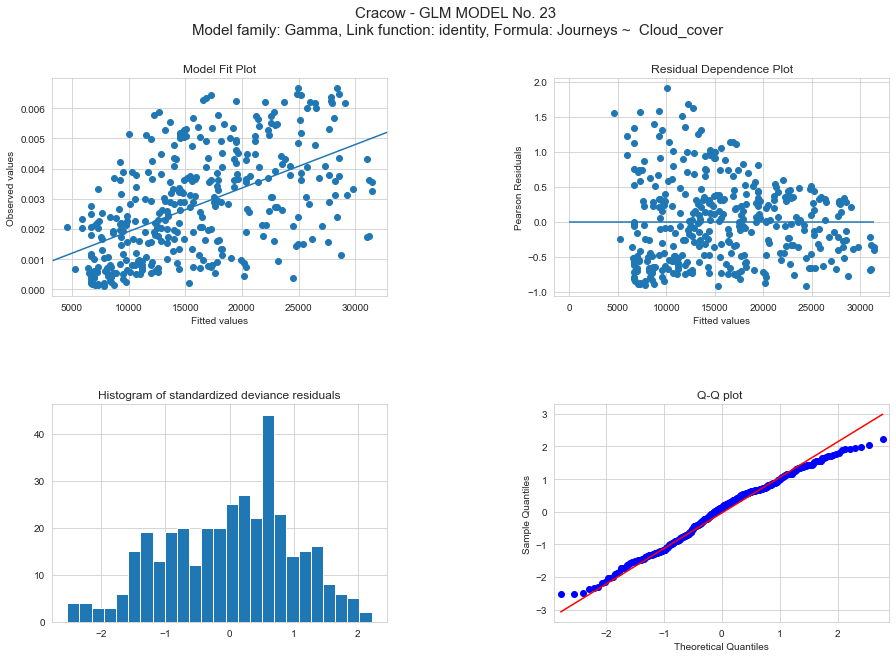

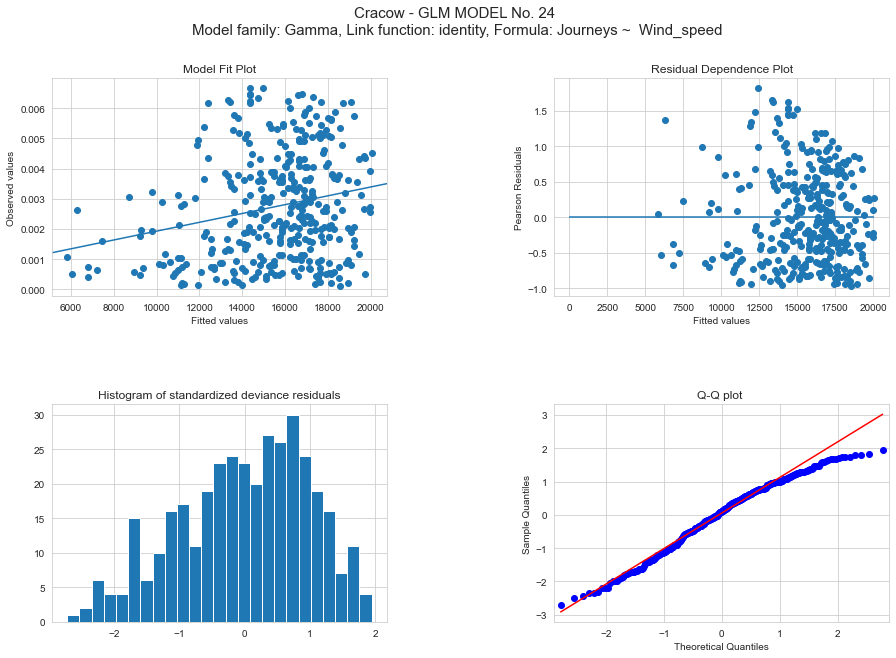

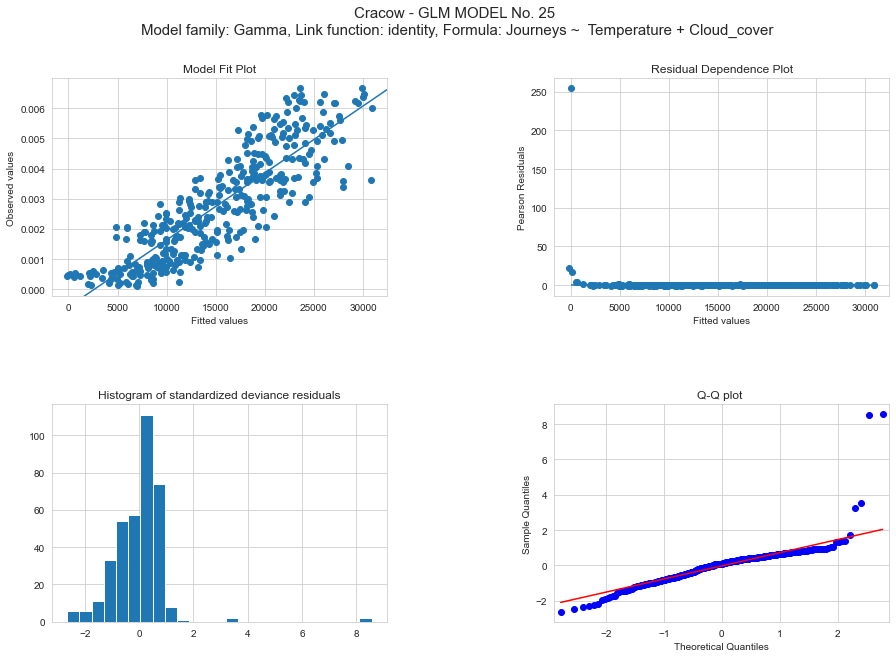

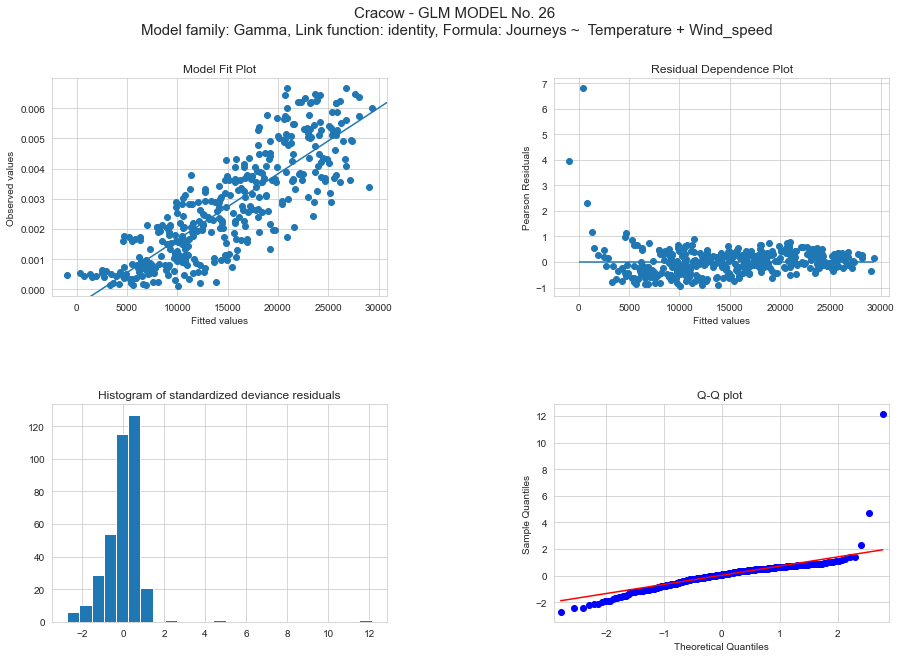

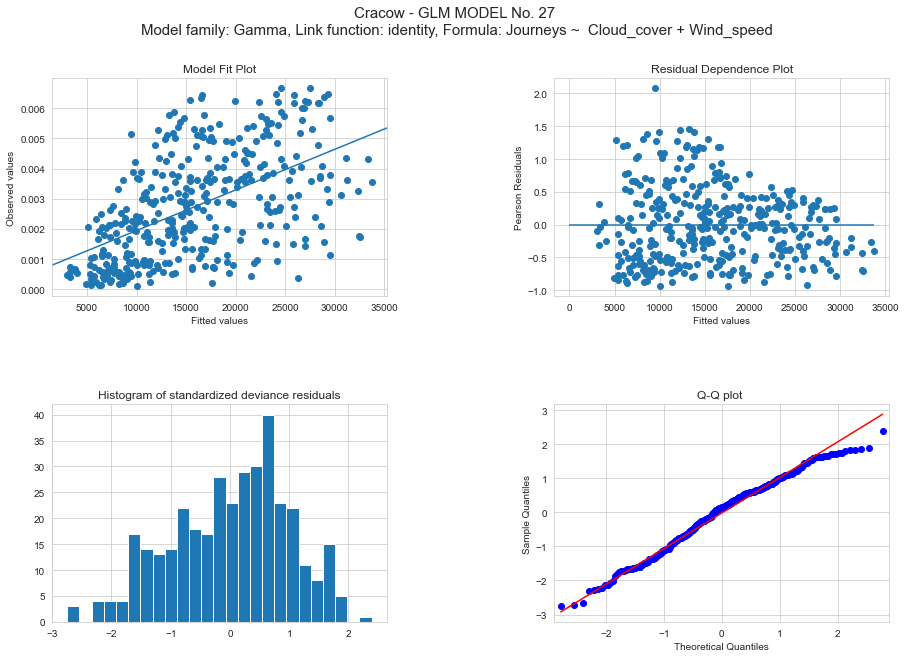

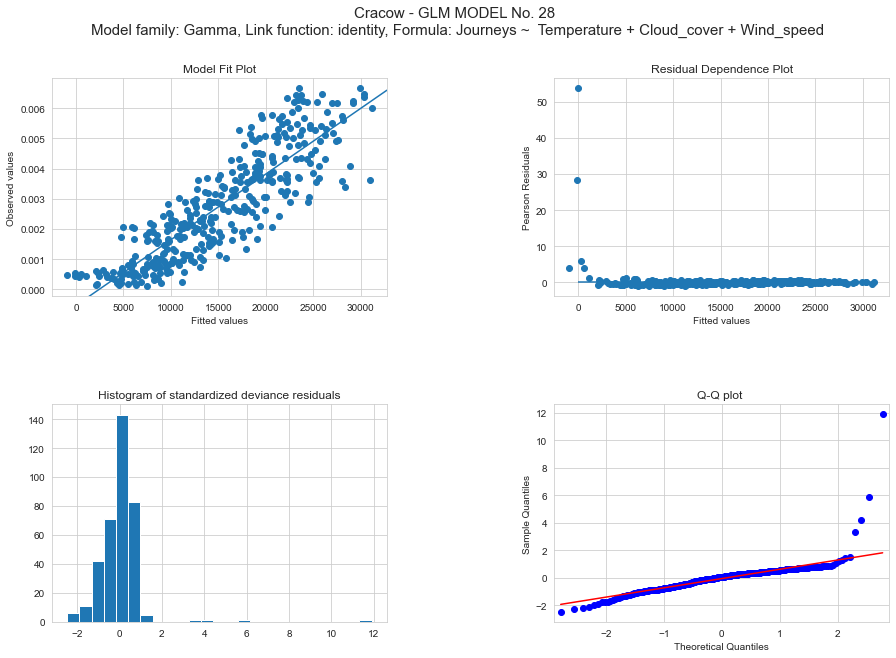

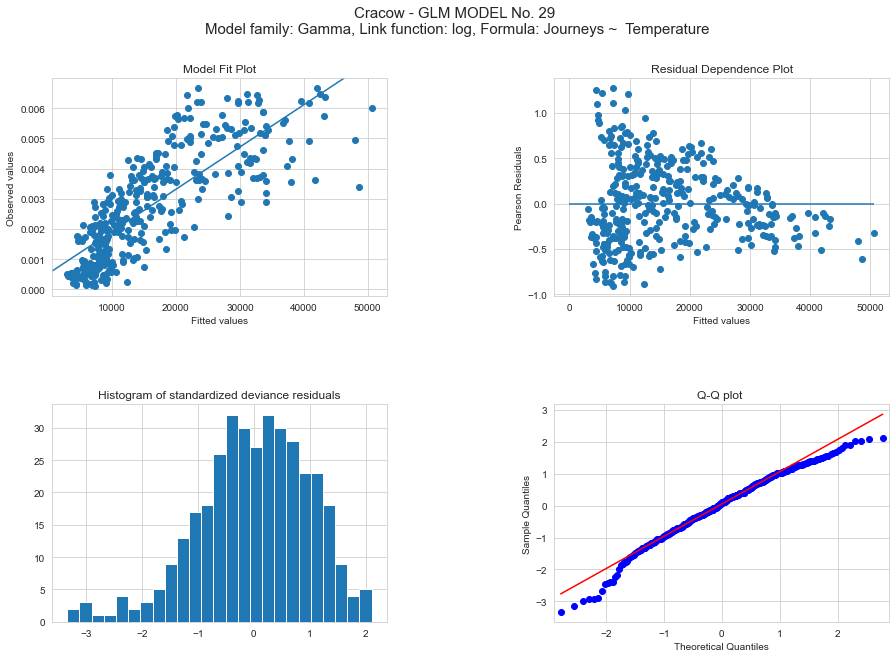

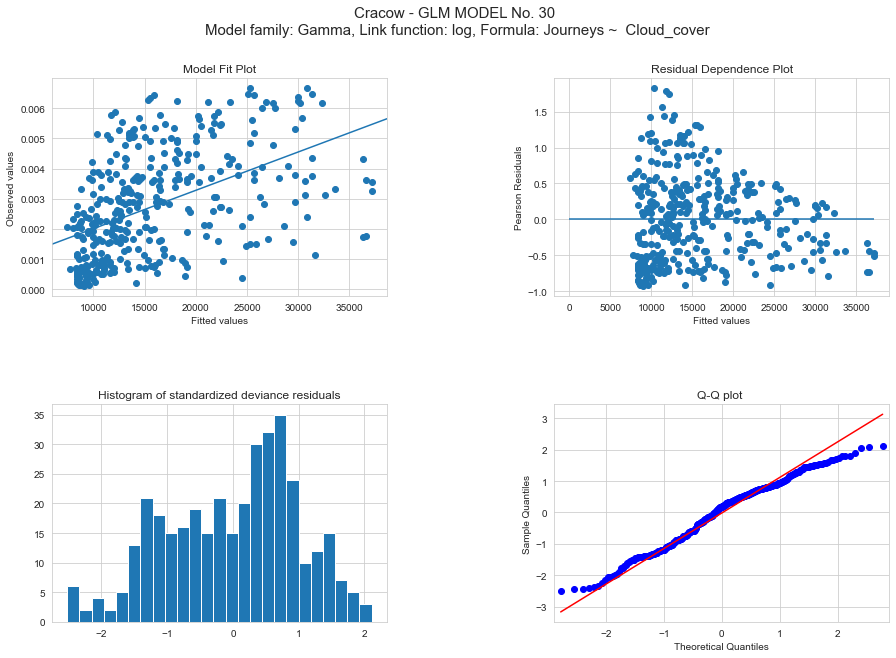

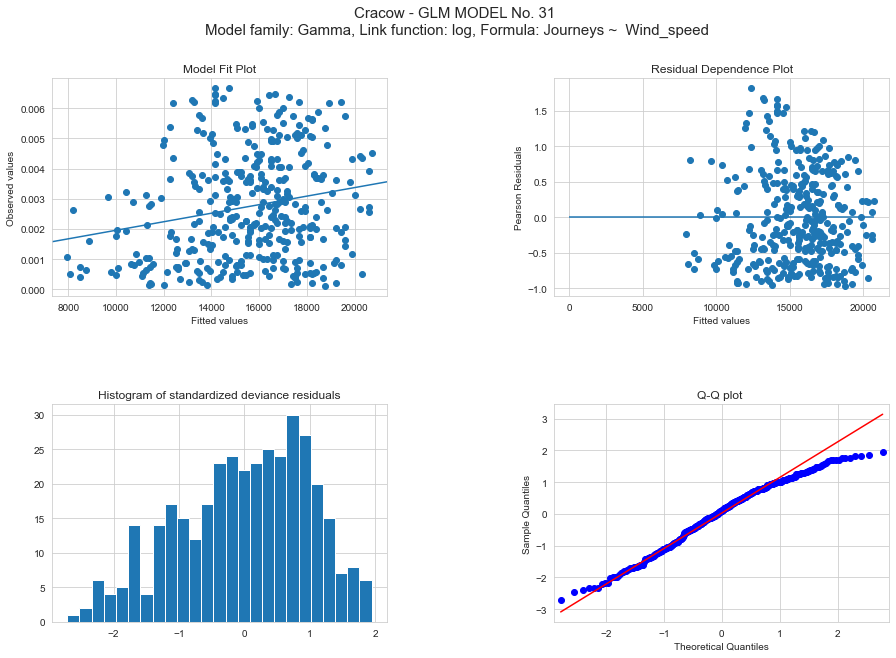

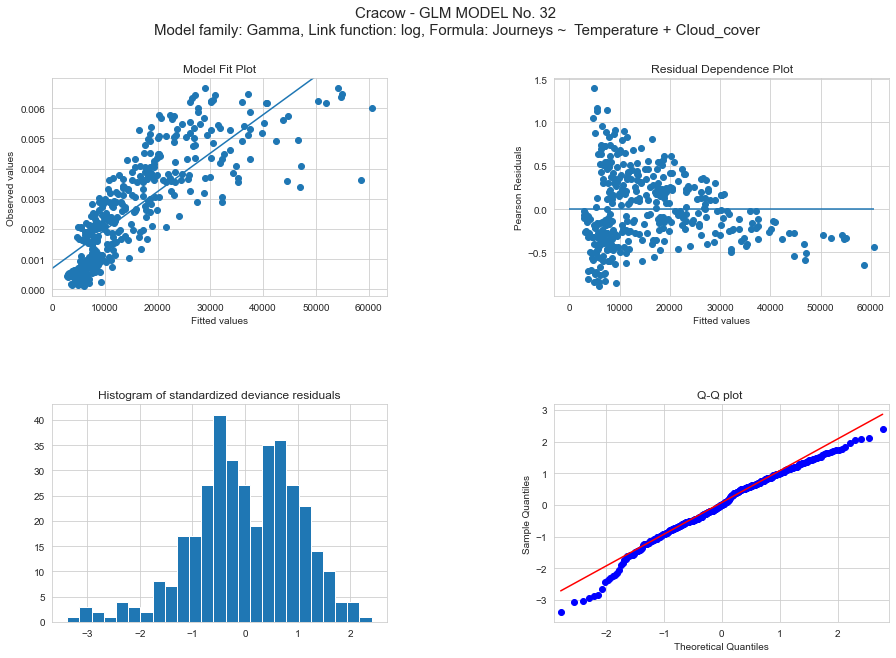

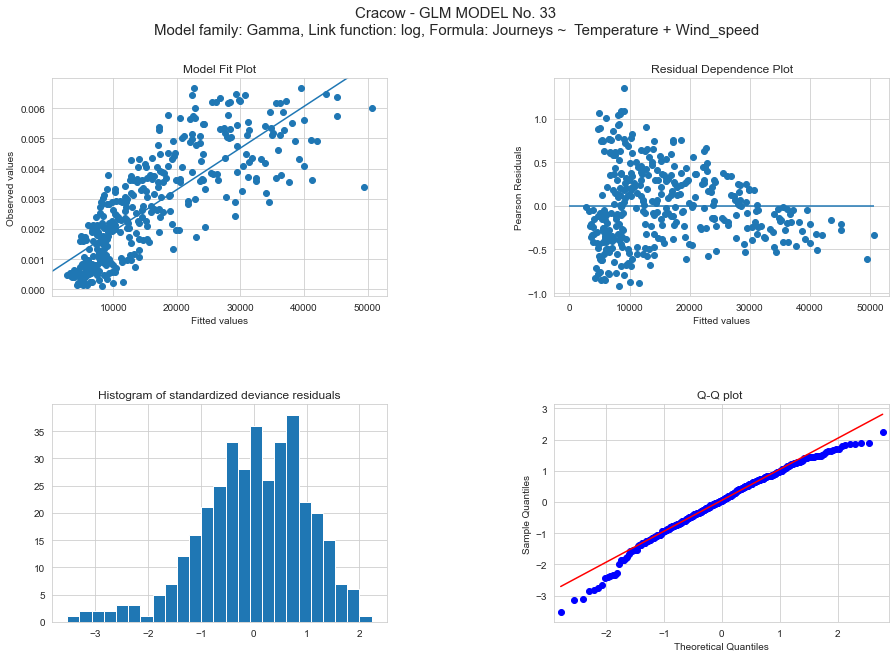

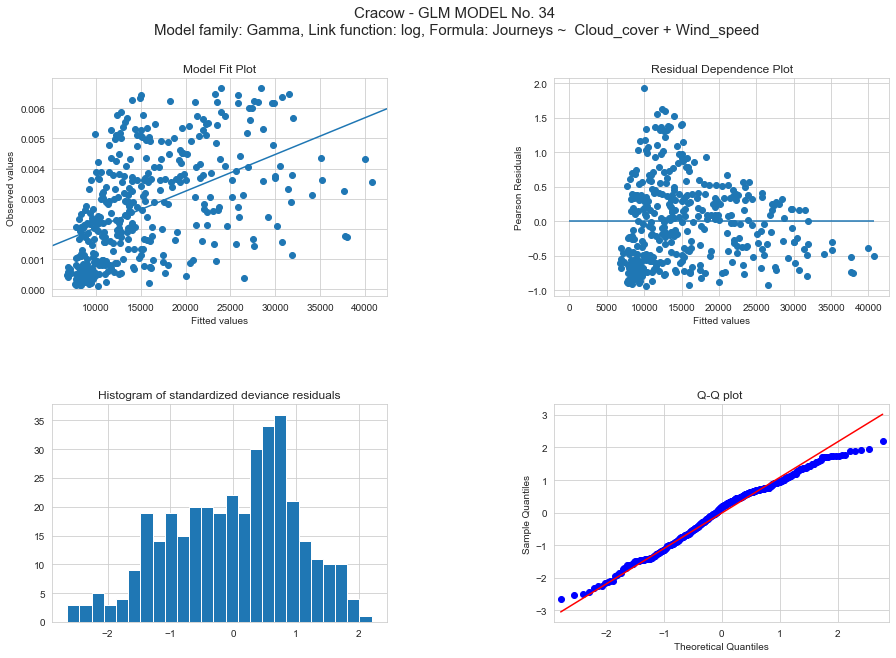

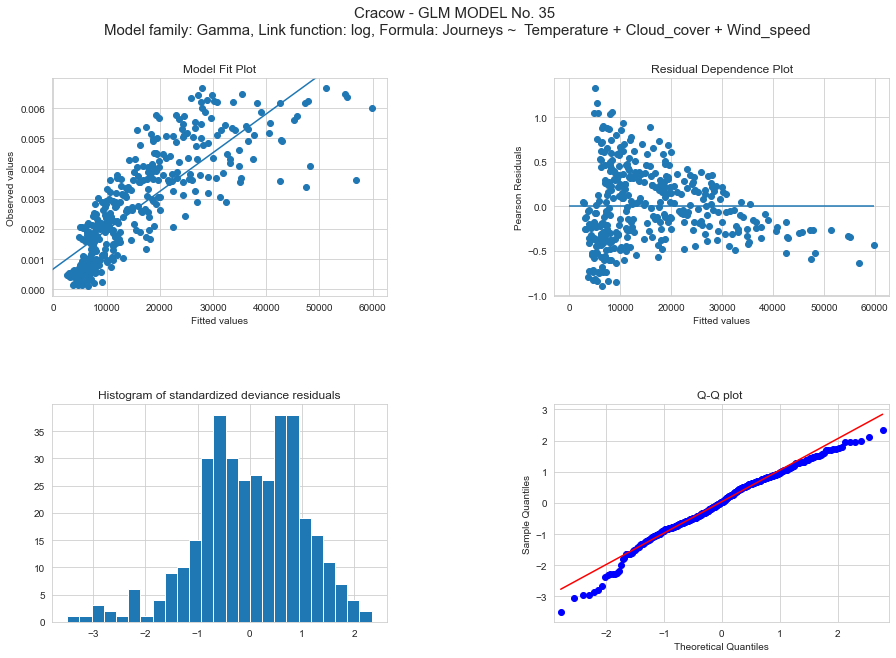

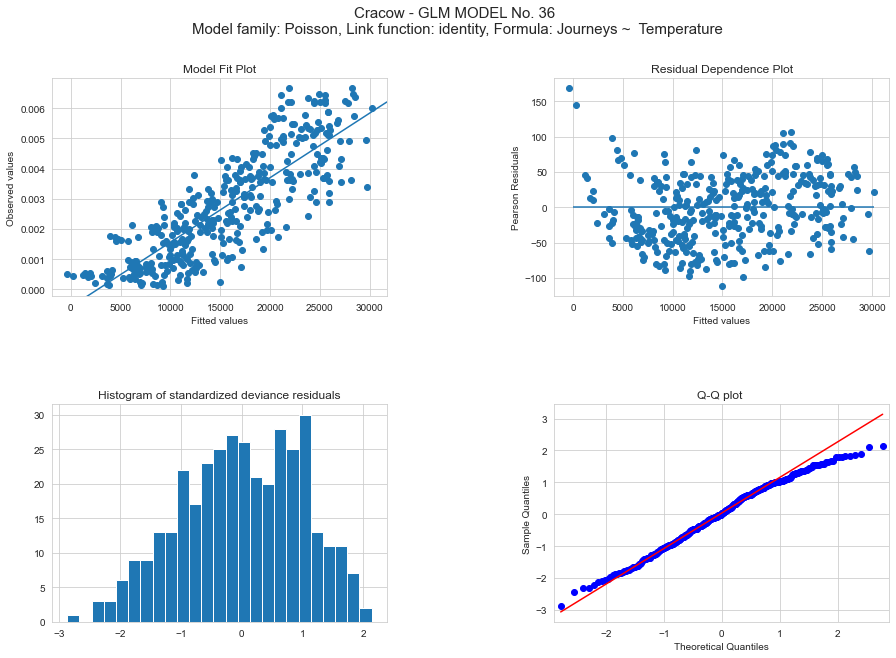

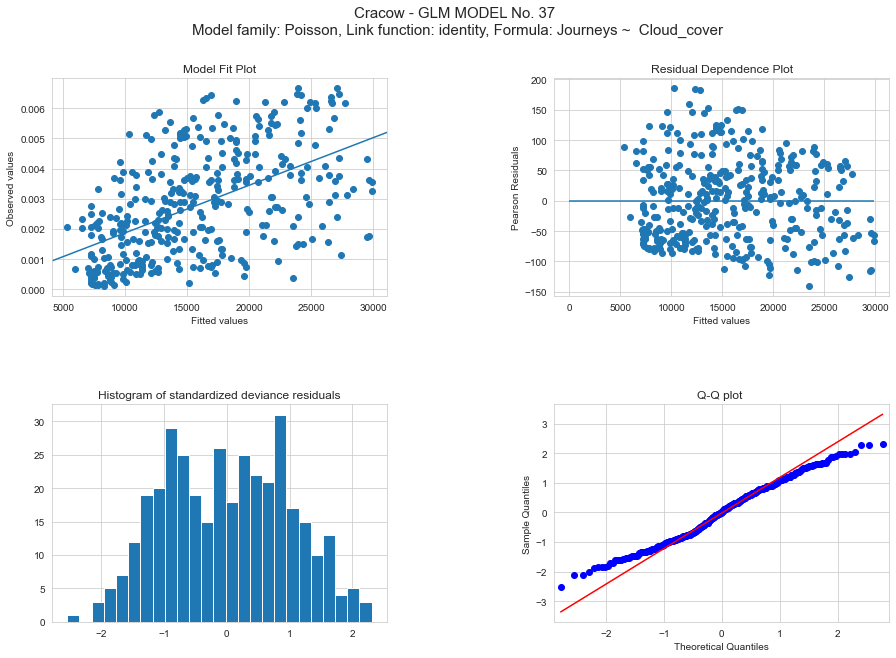

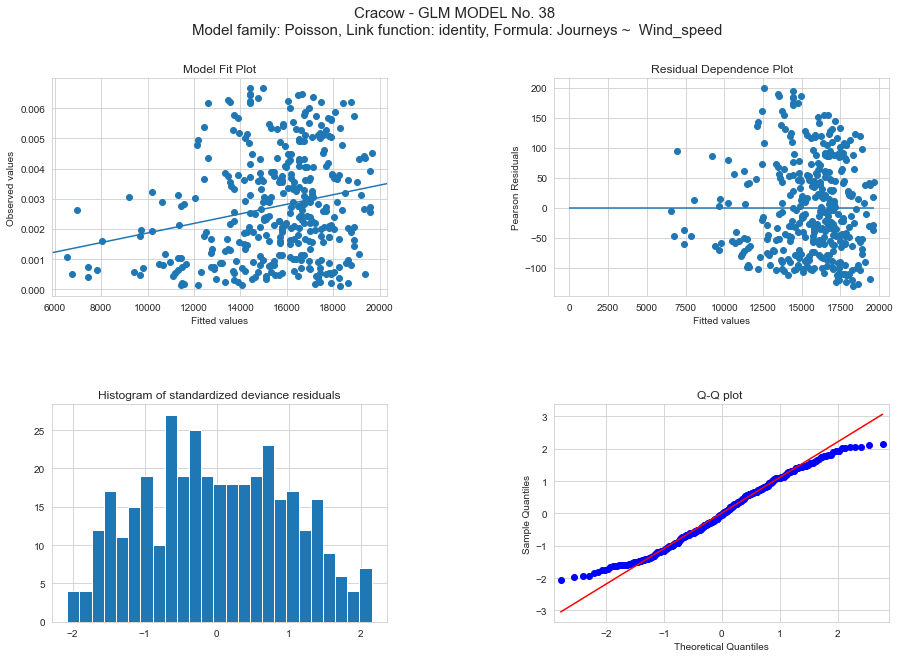

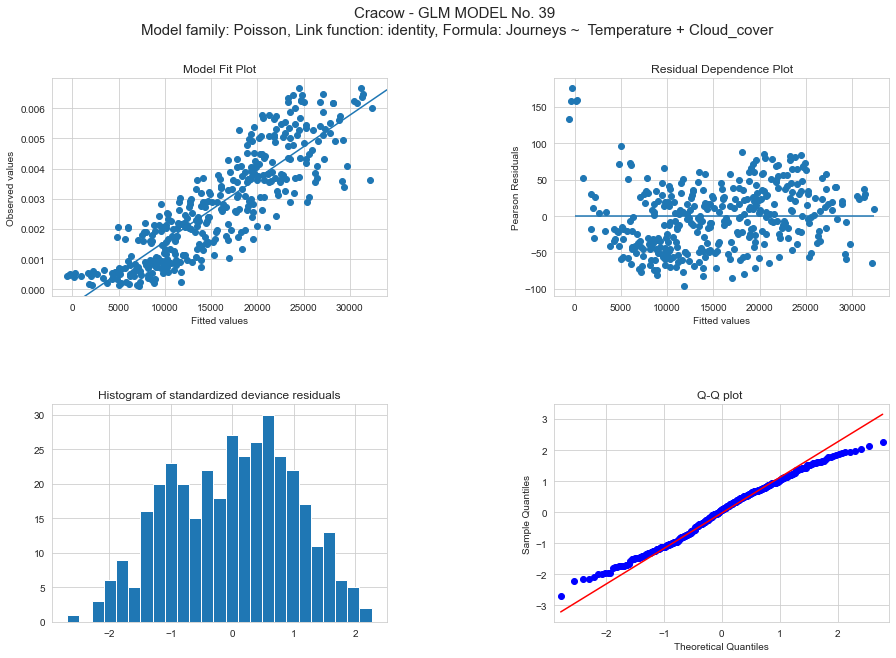

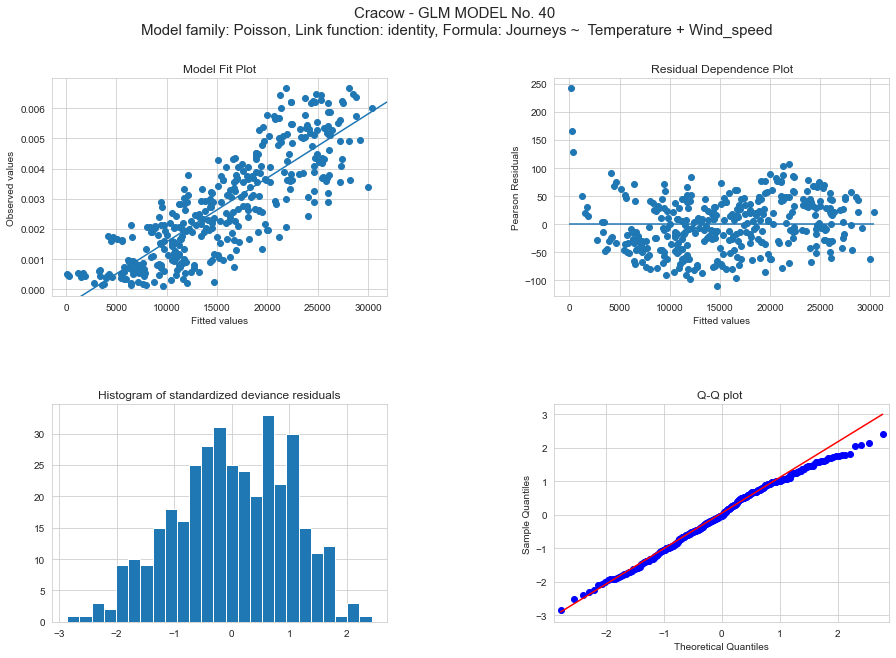

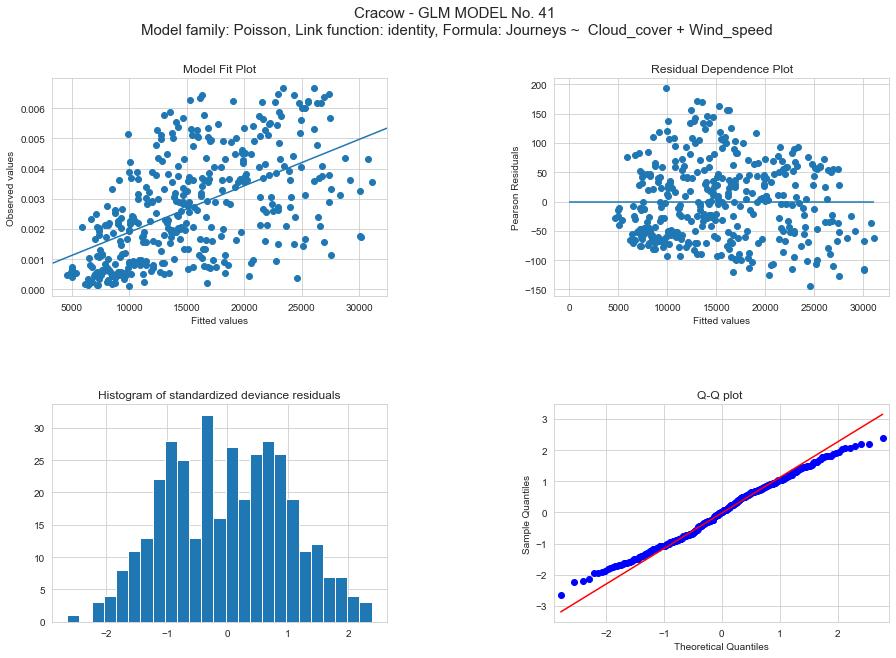

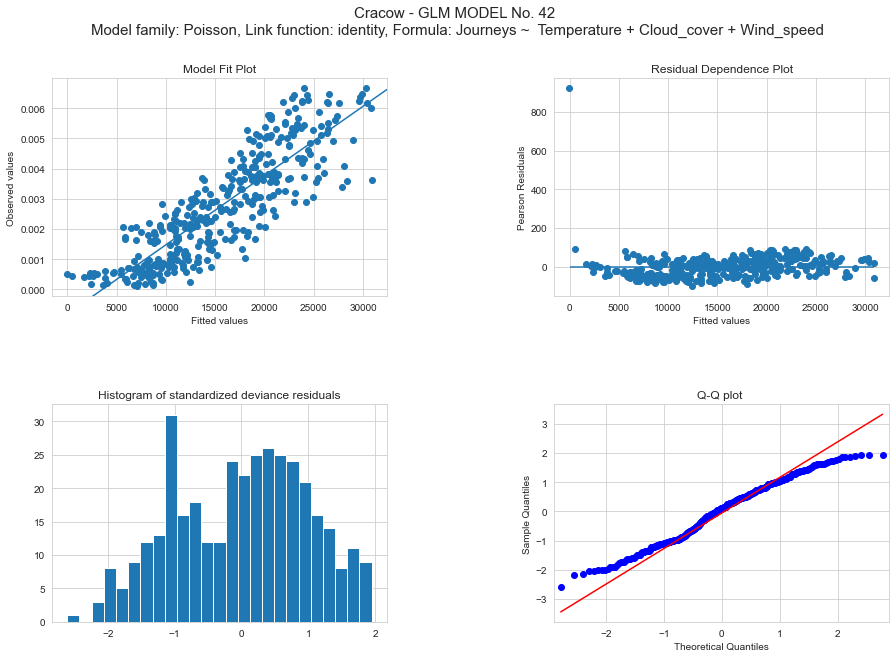

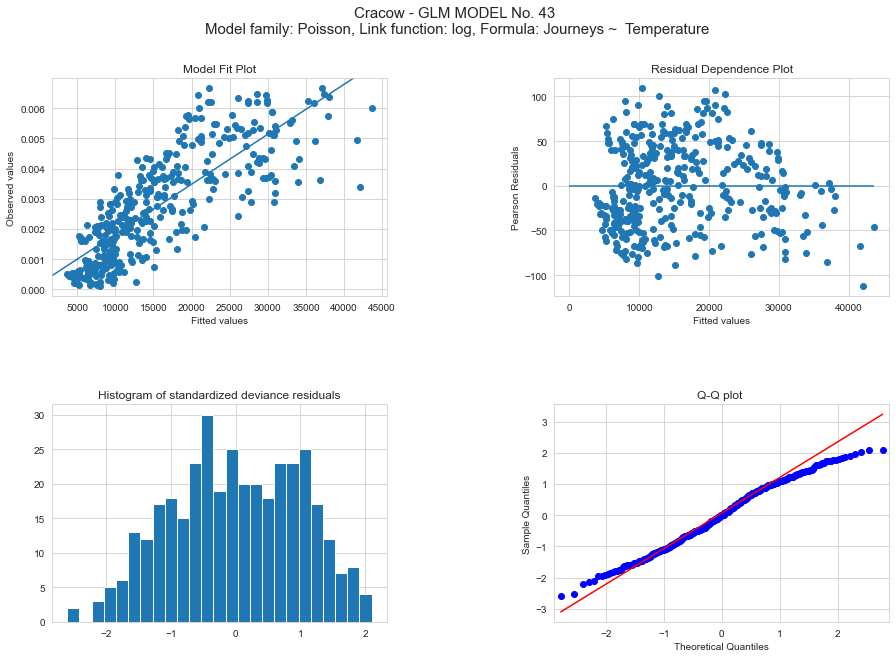

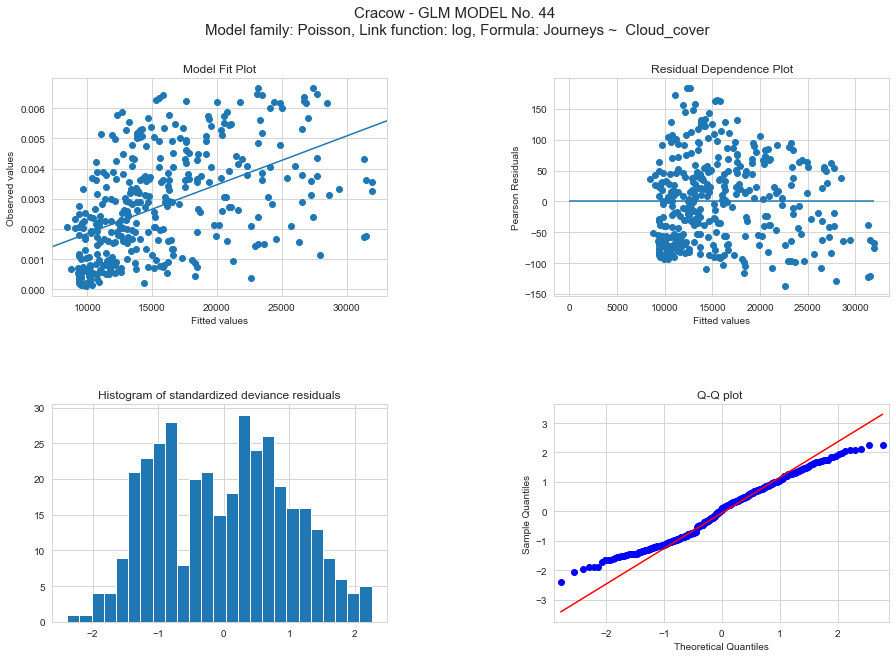

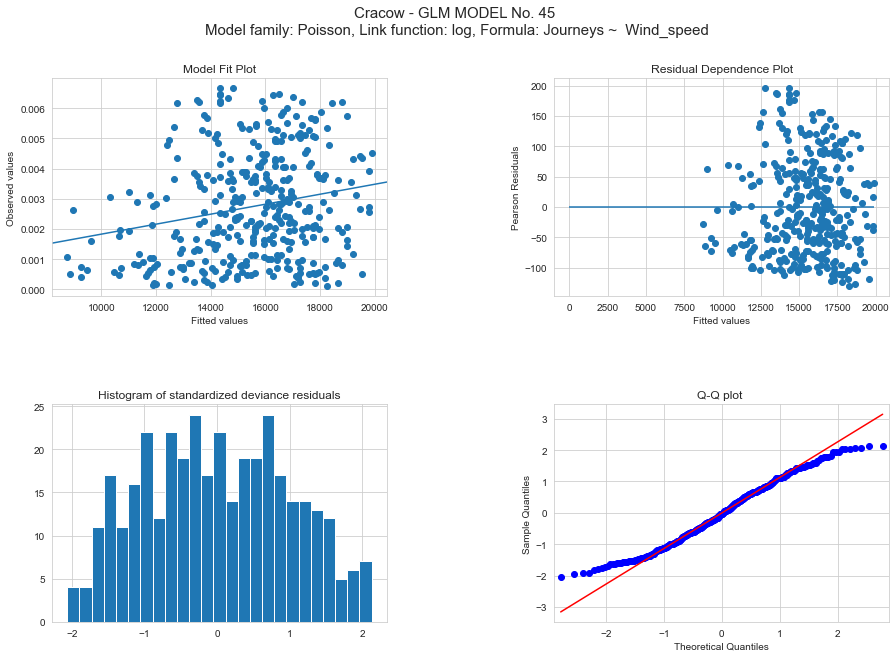

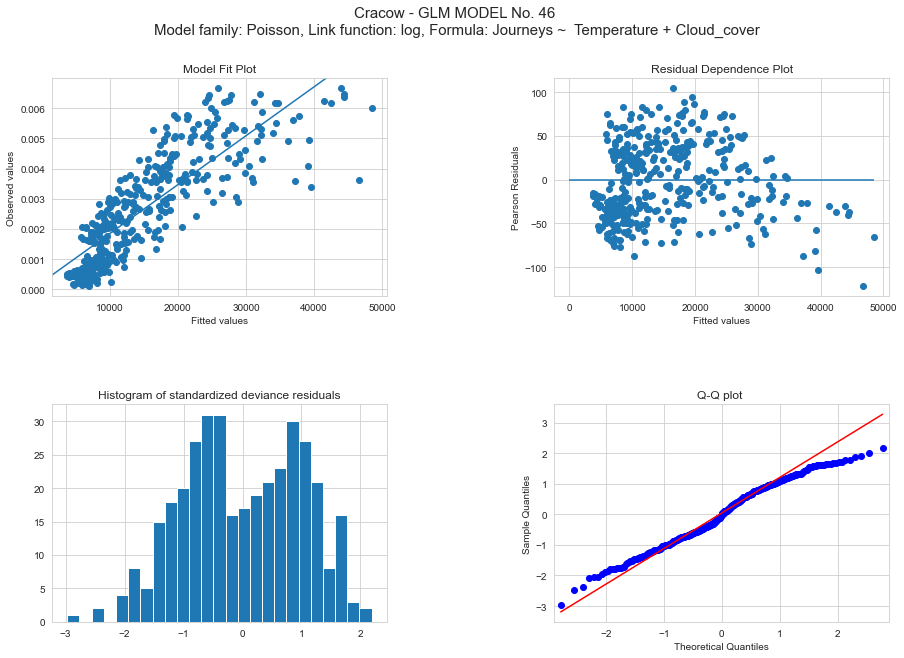

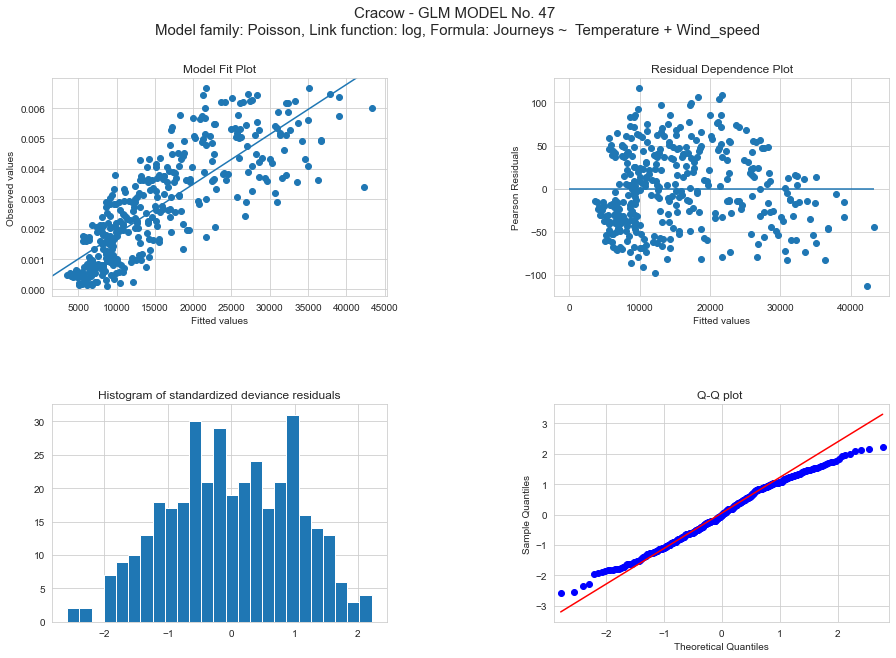

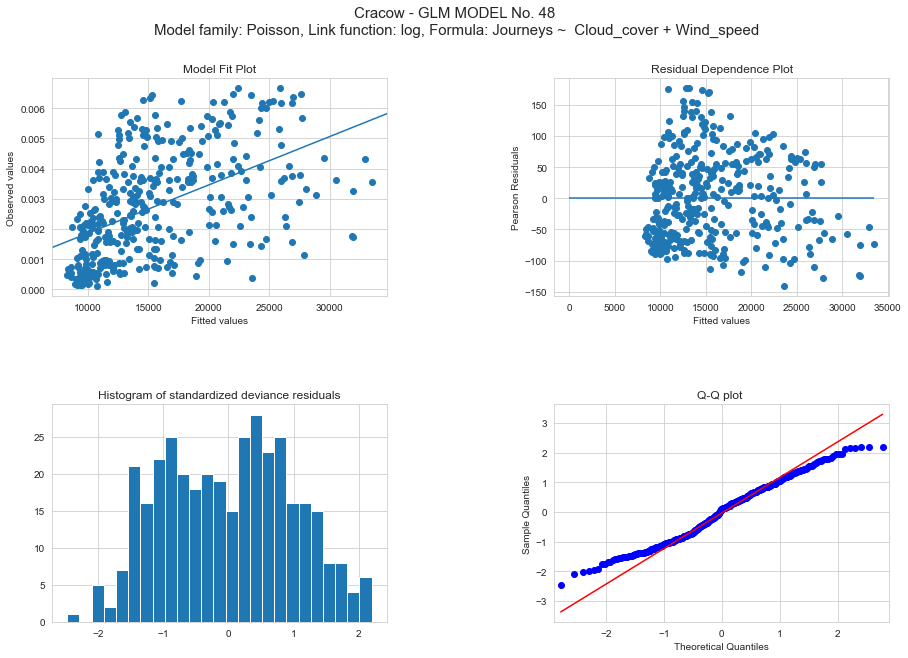

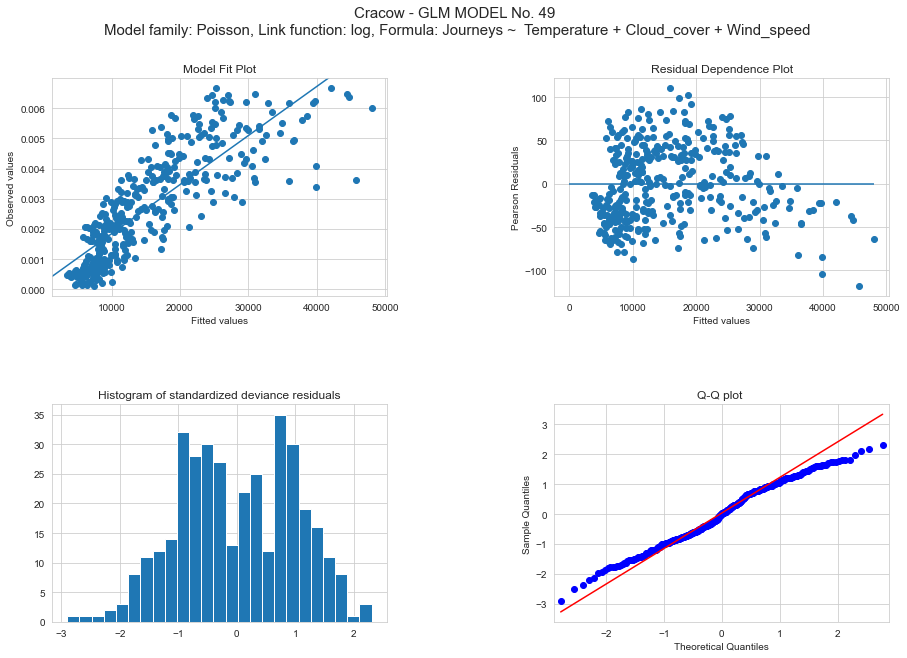

In [14]:
explained_variable = cracow.Journeys
constant = 'Journeys ~ '
result_table = []
a=1
y = explained_variable[:,]/explained_variable.sum()

for i in range(0,len(familia)):
    for x in range(0,len(formula)):
        print('Model No.',a)
        mod = smf.glm(formula=constant+formula[x], data=cracow, family=familia[i]).fit()
        yhat = mod.mu
        form = formula[x]
        result_table.append([f'Model No. {a}',form,(math.sqrt(mod.df_resid/abs(mod.deviance))),round(mod.aic,2), r2_score(explained_variable,mod.mu), familia2[i], mod.summary2().tables[0][1][1]])
        print('\n\n')
        print(mod.summary())
        #### Wykresy ----------------------------------------------------------------------------
        figGLM = plt.figure(figsize=[15,10])
        plt.subplots_adjust(wspace=0.5, hspace=0.5)
        plt.suptitle(f'Cracow - GLM MODEL No. {a} \nModel family: {familia2[i]}, Link function: {mod.summary2().tables[0][1][1]}, Formula: {constant} {form}', fontsize=15)

        ax1GLM = figGLM.add_subplot(221)
        ax1GLM.scatter(yhat, y)
        line_fit = sm.OLS(y, sm.add_constant(yhat, prepend=True)).fit()
        abline_plot(model_results=line_fit, ax=ax1GLM)
        ax1GLM.set_title('Model Fit Plot')
        ax1GLM.set_ylabel('Observed values')
        ax1GLM.set_xlabel('Fitted values')

        ax2GLM = figGLM.add_subplot(222)
        ax2GLM.scatter(yhat, mod.resid_pearson)
        ax2GLM.hlines(0, 0, yhat.max())
        ax2GLM.set_title('Residual Dependence Plot')
        ax2GLM.set_ylabel('Pearson Residuals')
        ax2GLM.set_xlabel('Fitted values')

        ax3GLM = figGLM.add_subplot(223)
        resid = mod.resid_deviance.copy()
        resid_std = stats.zscore(resid)
        ax3GLM.hist(resid_std, bins=25)
        ax3GLM.set_title('Histogram of standardized deviance residuals')

        ax4GLM = figGLM.add_subplot(224)
        ax4GLM.set_title('Q-Q plot ')
        sm.qqplot(resid, fit = True, line='q', ax = ax4GLM)
        plt.plot()
        print('AIC: ',round(mod.aic,2),'McFadden: ',r2_score(explained_variable,mod.mu))
        print('\n\n')
        a += 1

In [15]:
result_GLM = pd.DataFrame(result_table)

In [16]:
result_GLM.rename(columns={0:'Model',1:'Formula',2:'residuals_std_dev',3:'AIC',4:'McFadden',5:'Family',6:'Link'},inplace=True)

In [17]:
result_GLM.loc[result_GLM.AIC.isnull()]

Model                                 Formula  residuals_std_dev  \
35  Model No. 36                             Temperature           0.023771   
38  Model No. 39               Temperature + Cloud_cover           0.063220   
41  Model No. 42  Temperature + Cloud_cover + Wind_speed           0.025023   

    AIC  McFadden   Family      Link  
35  NaN  0.677294  Poisson  identity  
38  NaN  0.736856  Poisson  identity  
41  NaN  0.702644  Poisson  identity

In [18]:
result_GLM.sort_values(['AIC','McFadden'], ascending=[True,False]).head(10)

Model                                 Formula  residuals_std_dev  \
34  Model No. 35  Temperature + Cloud_cover + Wind_speed           2.187853   
31  Model No. 32               Temperature + Cloud_cover           2.177142   
6    Model No. 7  Temperature + Cloud_cover + Wind_speed           0.000185   
3    Model No. 4               Temperature + Cloud_cover           0.000185   
4    Model No. 5                Temperature + Wind_speed           0.000175   
0    Model No. 1                             Temperature           0.000173   
32  Model No. 33                Temperature + Wind_speed           2.052135   
28  Model No. 29                             Temperature           2.017231   
26  Model No. 27                Cloud_cover + Wind_speed           1.541585   
22  Model No. 23                             Cloud_cover           1.508344   

        AIC  McFadden    Family      Link  
34  7310.49  0.571498     Gamma       log  
31  7313.32  0.560822     Gamma       log  
6   7313.62  0.710752  Gaussian       log  
3   7315.19  0.707897  Gaussian       log  
4   7355.01  0.674223  Gaussian       log  
0   7359.61  0.668277  Gaussian       log  
32  7360.11  0.595956     Gamma       log  
28  7372.38  0.599278     Gamma       log  
26  7579.24  0.263815     Gamma  identity  
22  7594.46  0.275741     Gamma  identity

CONCLUSION: The best GLM model (Model No.35) for Cracow at full harvest did not achieve better results than the regular ML.

<hr>  